In [37]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Definindo as funções

# splines naturais

class NaturalCubicSpline:
    def __init__(self, lx, ly):
        self.lx = lx
        self.ly = ly
        self.n = len(lx)
        self.a = self.ly[:-1]
        self.b, self.c, self.d = self.gera_spline()
        self.coefs = [np.array(self.a), self.b, self.c, self.d]
    def gera_spline(self):
        # implementação do algorítmo 3.4
        h = list()
        for i in range(self.n - 1):
            h.append(self.lx[i + 1] - self.lx[i])
        alpha = [0.0]
        for i in range(1, self.n - 1):
            res = (3 * (self.ly[i + 1] - self.ly[i]) / h[i]) - ( 3 * (self.ly[i] - self.ly[i - 1]) / h[i - 1] )
            alpha.append(res)
        l = [1.0]
        u = [0.0]
        z = [0.0]
        for i in range(1, self.n - 1):
            l.append(2 * (self.lx[i + 1] - self.lx[i - 1]) - (h[i - 1] * u[i - 1]))
            u.append(h[i] / l[i])
            z.append((alpha[i] - h[i - 1] * z[i - 1]) / l[i])
        l.append(1.0)
        z.append(0.0)
        b = np.array([0.0 for i in range(self.n)])
        c = np.array([0.0 for i in range(self.n)])
        d = np.array([0.0 for i in range(self.n)])
        for j in range(self.n - 2, -1, -1):
            c[j] = z[j] - u[j] * c[j + 1]
            b[j] = (self.ly[j + 1] - self.ly[j]) / h[j] - h[j] * ( c[j + 1] + 2 * c[j] ) / 3
            d[j] = (c[j + 1] - c[j]) / (3 * h[j])
        return b[:-1], c[:-1], d[:-1]

    def polinom(self, p):
        # P(x) aplicado em x=p
        if p < self.lx[0] or p > self.lx[self.n - 1]:
            return 0
        for i in range(self.n - 1):
            if p >= self.lx[i] and p <= self.lx[i+1]:
                X = p - self.lx[i]
                return (  self.a[i] + self.b[i] * X + self.c[i] * X ** 2 + self.d[i] * X ** 3 )


# splines fixados

class ClampedCubicSpline: 
    def __init__(self, lx, ly, FPO, FPN):
        self.lx = lx
        self.ly = ly
        self.n = len(lx)
        self.a = self.ly[:-1]
        self.FPO = FPO
        self.FPN = FPN
        self.b, self.c, self.d = self.gera_spline()
        self.coefs = [np.array(self.a), self.b, self.c, self.d]
    def gera_spline(self):
        # implementação do algorítmo 3.5
        h = list()
        for i in range(self.n - 1):
            h.append(self.lx[i + 1] - self.lx[i])
        alpha = [3*(self.ly[1]-self.ly[0])/h[0] - 3*self.FPO]
        for i in range(1,self.n-1):
            res = (3 * (self.ly[i + 1] - self.ly[i]) / h[i]) - (3 * (self.ly[i] - self.ly[i - 1]) / h[i - 1])
            alpha.append(res)
        alpha.append(3*self.FPN - 3*(self.ly[self.n-1]-self.ly[self.n-2])/h[self.n-2])
        l = [2*h[0]]
        u = [0.5]
        z = [alpha[0]/l[0]]
        for i in range(1, self.n - 1):
            l.append(2 * (self.lx[i + 1] - self.lx[i - 1]) - (h[i - 1] * u[i - 1]))
            u.append(h[i] / l[i])
            z.append((alpha[i] - h[i - 1] * z[i - 1]) / l[i])
        l.append(h[self.n-2]*(2-u[self.n-2]))  ###
        z.append((alpha[self.n-1]-h[self.n-2]*z[self.n-2])/l[self.n-1])

        b = np.array([0.0 for i in range(self.n)])
        c = np.array([0.0 for i in range(self.n)])
        d = np.array([0.0 for i in range(self.n)])
        c[self.n-1] = z[self.n-1]

        for j in range(self.n - 2, -1, -1):
            c[j] = z[j] - u[j] * c[j + 1]
            b[j] = (self.ly[j + 1] - self.ly[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
            d[j] = (c[j + 1] - c[j]) / (3 * h[j])
        return b[:-1], c[:-1], d[:-1]


    def polinom(self, p):
         # P(x) aplicado em x=p
        if p < self.lx[0] or p > self.lx[self.n - 1]:
            return 0
        for i in range(self.n-1):
            if p >= self.lx[i] and p <= self.lx[i+1]:
                X = p - self.lx[i]
                return self.a[i] + self.b[i] * X + self.c[i] * X ** 2 + self.d[i] * X ** 3


# polinômio interpolador por diferenças divididas

class DividedDiferences:
    def __init__(self, x, y):
        # x vetor de mesmo tamanho que y
        self.x = np.array(x,dtype=np.float64)
        self.y = np.array(y,dtype=np.float64)
        self.n = len(x)
        f = np.zeros((self.n, self.n))
        for k in range(self.n):
            f[k, 0] = self.y[k]
        # algorítmo
        for i in range(1, self.n):
            for j in range(1, i + 1):
                f[i, j] = (f[i, j - 1] - f[i - 1, j - 1]) / (self.x[i] - self.x[i - j])
        self.coefs = f

    def polinom(self, p):
        soma = 0
        for i in range(self.n):
            res = self.coefs[i, i]
            for j in range(i):
                res *= p - self.x[j]
            soma += res
        return soma




_____________________
RUDDY DUCK IN FLIGHT


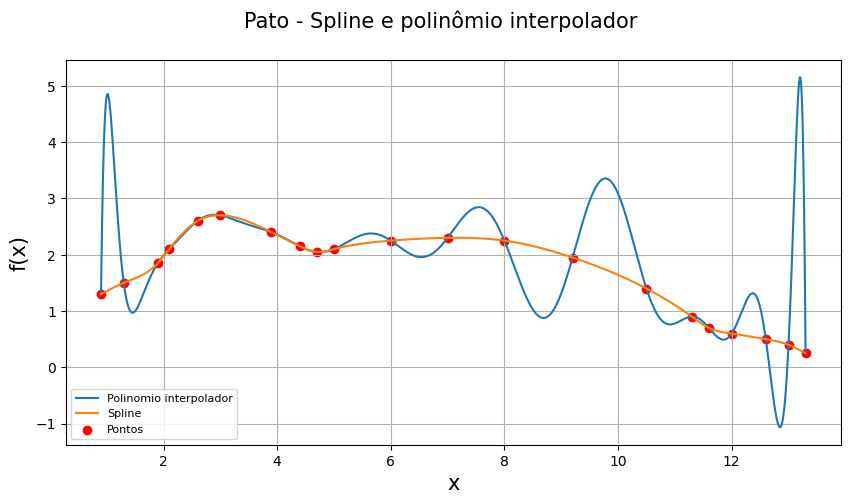

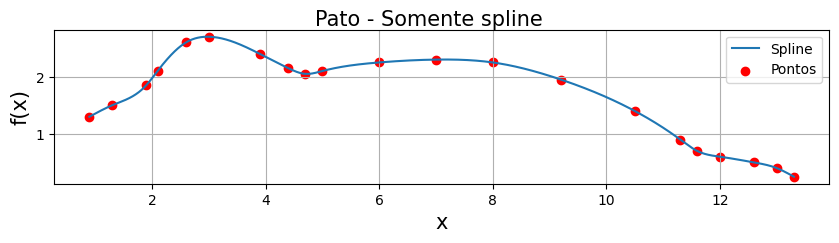

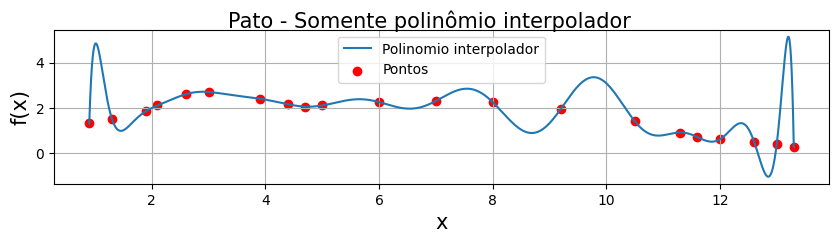


Pato - os coeficientes do spline são: 
      Aj        Bj        Cj        Dj
j                                     
0   1.30  0.539624  0.000000 -0.247649
1   1.50  0.420752 -0.297179  0.946912
2   1.85  1.086803  1.407263 -2.956382
3   2.10  1.294942 -0.366567 -0.446635
4   2.60  0.593399 -1.036519  0.445051
5   2.70 -0.022191 -0.502457  0.174160
6   2.40 -0.503406 -0.032226  0.078076
7   2.15 -0.477075  0.084888  1.314171
8   2.05 -0.071316  1.267642 -1.581219
9   2.10  0.262340 -0.155455  0.043115
10  2.25  0.080776 -0.026109 -0.004666
11  2.30  0.014558 -0.040108 -0.024450
12  2.25 -0.139008 -0.113458  0.017471
13  1.95 -0.335834 -0.050564 -0.012728
14  1.40 -0.531830 -0.100202 -0.020325
15  0.90 -0.731178 -0.148983  1.213405
16  0.70 -0.492949  0.943082 -0.839275
17  0.60 -0.141335 -0.064048  0.036382
18  0.50 -0.178900  0.001440 -0.447971
19  0.40 -0.392775 -0.536126  0.595695

Pato - os coeficientes do polinômio interpolador são: 
    coeficientes
0   1.300000e+00
1   5.000000

In [38]:
# Aplicação 1
### Ruddy duck in flight

print('_____________________')
print('RUDDY DUCK IN FLIGHT')
X = [0.9,1.3,1.9,2.1,2.6,3.0,3.9,4.4,4.7,5.0,6.0,7.0,8.0,9.2,10.5,11.3,11.6,12.0,12.6,13.0,13.3]
Y = [1.3,1.5,1.85,2.1,2.6,2.7,2.4,2.15,2.05,2.1,2.25,2.3,2.25,1.95,1.4,0.9,0.7,0.6,0.5,0.4,0.25]

patoSpline = NaturalCubicSpline(X,Y)
patoPolinomio = DividedDiferences(X,Y)

Xbase = np.linspace(0.9,13.3,100000)
YSpline = [patoSpline.polinom(x) for x in Xbase]
YPolinomio = [patoPolinomio.polinom(x) for x in Xbase]

fig1 = plt.figure(figsize = (10,5))
fig1.suptitle('Pato - Spline e polinômio interpolador', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, YPolinomio, label = "Polinomio interpolador")
plt.plot(Xbase, YSpline, label = "Spline")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=8)
plt.show()

fig2 = plt.figure(figsize = (10,2))
fig2.suptitle('Pato - Somente spline', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, YSpline, label = "Spline")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)
plt.show()

fig3 = plt.figure(figsize = (10,2))
fig3.suptitle('Pato - Somente polinômio interpolador', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, YPolinomio, label = "Polinomio interpolador")
plt.scatter(X, Y, label = "Pontos", color = "r")
plt.legend(fontsize=10)
plt.show()

# coeficientes spline
print()
print('Pato - os coeficientes do spline são: ')
print(pd.DataFrame({'Aj':patoSpline.a,'Bj':patoSpline.b,'Cj':patoSpline.c,'Dj':patoSpline.d,'j':range(len(patoSpline.a))}).set_index('j'))

# coeficientes polinomio de newton
print()
print('Pato - os coeficientes do polinômio interpolador são: ')
print(pd.DataFrame({'coeficientes':[patoPolinomio.coefs[i,i] for i in range(len(patoPolinomio.coefs))]}))



In [39]:
#pd.DataFrame({'Aj':patoSpline.a,'Bj':patoSpline.b,'Cj':patoSpline.c,'Dj':patoSpline.d,'j':range(len(patoSpline.a))}).set_index('j')
pd.DataFrame({'coeficientes':[patoPolinomio.coefs[i,i] for i in range(len(patoPolinomio.coefs))]})


,coeficientes
0,1.300000e+00
1,5.000000e-01
2,8.333333e-02
3,6.250000e-01
4,-9.063241e-01
5,5.668351e-01
6,-1.839119e-01
7,3.874691e-02
8,-2.548150e-03
9,-1.858675e-03


In [40]:

### Noble beast

print('_____________________')
print('NOBLE BEAST')
X1 = [1,2,5,6,7,8,10,13,17]
Y1 = [3.0,3.7,3.9,4.2,5.7,6.6,7.1,6.7,4.5]
FPO1 = 1.0
FPN1 = -0.67

X2 = [17,20,23,24,25,27,27.7]
Y2 = [4.5,7.0,6.1,5.6,5.8,5.2,4.1]
FPO2 = 3.0
FPN2 = -4.0

X3 = [27.7,28,29,30]
Y3 = [4.1,4.3,4.1,3.0]
FPO3 = 0.33
FPN3 = -1.5

X = [1,2,5,6,7,8,10,13,17,20,23,24,25,27,27.7,28,29,30]
Y =  [3.0,3.7,3.9,4.2,5.7,6.6,7.1,6.7,4.5,7.0,6.1,5.6,5.8,5.2,4.1,4.3,4.1,3.0]

cachorro1 = ClampedCubicSpline(X1,Y1,FPO1,FPN1)
cachorro2 = ClampedCubicSpline(X2,Y2,FPO2,FPN2)
cachorro3 = ClampedCubicSpline(X3,Y3,FPO3,FPN3)


def splineCachorro(x):
    if x <= 17:
        return cachorro1.polinom(x)
    if x <= 27.7:
        return cachorro2.polinom(x)
    else:
        return cachorro3.polinom(x)

cachorroPolinomio = DividedDiferences(X,Y)

Xbase = np.linspace(1,30,30000)
YSpline = [splineCachorro(x) for x in Xbase]
YPolinomio = [cachorroPolinomio.polinom(x) for x in Xbase]

# fig1 = plt.figure(figsize = (10,5))
# fig1.suptitle('Cachorro - Spline e polinômio interpolador', fontsize = 15)
# plt.xlabel('x', fontsize = 15)
# plt.ylabel('f(x)', fontsize = 15)
# plt.grid()
# plt.plot(Xbase, YPolinomio, label = "Polinômio interpolador")
# plt.plot(Xbase, YSpline, label = "Splines")
# plt.scatter(X, Y, label = "Pontos", color = "r")
# plt.legend(fontsize=10)
# plt.show()

# fig2 = plt.figure(figsize = (10,5))
# fig2.suptitle('Cachorro - Polinômio interpolador a partir de x=5 e spline', fontsize = 15)
# plt.xlabel('x', fontsize = 15)
# plt.ylabel('f(x)', fontsize = 15)
# plt.grid()
# plt.plot(Xbase[4150:], YPolinomio[4150:], label = "Polinômio interpolador")
# plt.plot(Xbase, YSpline, label = "Splines")
# plt.scatter(X, Y, label = "Pontos", color = "r")
# plt.legend(fontsize=10)
# plt.show()

# fig3 = plt.figure(figsize = (10,2))
# fig3.suptitle('Cachorro - Somente spline', fontsize = 15)
# plt.xlabel('x', fontsize = 15)
# plt.ylabel('f(x)', fontsize = 15)
# plt.grid()
# plt.plot(Xbase, YSpline, label = "Splines")
# plt.scatter(X, Y, label = "Pontos", color = "r")
# plt.legend(fontsize=10)
# plt.show()

# fig4 = plt.figure(figsize = (10,2))
# fig4.suptitle('Cachorro - Somente polinômio interpolador', fontsize = 15)
# plt.xlabel('x', fontsize = 15)
# plt.ylabel('f(x)', fontsize = 15)
# plt.grid()
# plt.plot(Xbase, YPolinomio, label = "Polinômio interpolador")
# plt.scatter(X, Y, label = "Pontos", color = "r")
# plt.legend(fontsize=10)
# plt.show()

# # coeficientes
# print()
# # print('Cachorro - os coeficientes do primeiro spline são: ')
# pd.DataFrame({'Aj':cachorro1.a,'Bj':cachorro1.b,'Cj':cachorro1.c,'Dj':cachorro1.d,'j':range(len(cachorro1.a))}).set_index('j')
# # print()
# # print('Cachorro - os coeficientes do segundo spline são: ')
# print(pd.DataFrame({'Aj':cachorro2.a,'Bj':cachorro2.b,'Cj':cachorro2.c,'Dj':cachorro2.d,'j':range(len(cachorro2.a))}).set_index('j'))
# # print()
# # print('Cachorro - os coeficientes do terceiro spline são: ')
# print(pd.DataFrame({'Aj':cachorro3.a,'Bj':cachorro3.b,'Cj':cachorro3.c,'Dj':cachorro3.d,'j':range(len(cachorro3.a))}).set_index('j'))

# # # coeficientes polinomio de newton
# # print()
# # print('Cachorro - os coeficientes do polinômio interpolador são: ')
# print(pd.DataFrame({'coeficientes':[cachorroPolinomio.coefs[i,i] for i in range(len(cachorroPolinomio.coefs))]}))




_____________________
NOBLE BEAST


In [41]:
#pd.DataFrame({'Xj':cachorro1.lx[:-1],'Aj':cachorro1.a,'Bj':cachorro1.b,'Cj':cachorro1.c,'Dj':cachorro1.d,'j':range(len(cachorro1.a))}).set_index('j')
#pd.DataFrame({'Aj':cachorro2.a,'Bj':cachorro2.b,'Cj':cachorro2.c,'Dj':cachorro2.d,'j':range(len(cachorro2.a))}).set_index('j')
#pd.DataFrame({'Aj':cachorro3.a,'Bj':cachorro3.b,'Cj':cachorro3.c,'Dj':cachorro3.d,'j':range(len(cachorro3.a))}).set_index('j')
pd.DataFrame({'coeficientes':[cachorroPolinomio.coefs[i,i] for i in range(len(cachorroPolinomio.coefs))]})

# coeficientes
# A_Cachorro = list(cachorro1.a) + list(cachorro2.a) + list(cachorro3.a)
# B_Cachorro = list(cachorro1.b) + list(cachorro2.b) + list(cachorro3.b)
# C_Cachorro = list(cachorro1.c) + list(cachorro2.c) + list(cachorro3.c)
# D_Cachorro = list(cachorro1.d) + list(cachorro2.d) + list(cachorro3.d)

# pd.DataFrame({
#     'Xj':[1,2,5,6,7,8,10,13,17,20,23,24,25,27,27.7,28,29],
#     'Aj':A_Cachorro,
#     'Bj':B_Cachorro,
#     'Cj':C_Cachorro,
#     'Dj':D_Cachorro,
#     'j':range(len(A_Cachorro))
# }).set_index('j')

,coeficientes
0,3.000000e+00
1,7.000000e-01
2,-1.583333e-01
3,4.333333e-02
4,1.083333e-02
5,-1.126984e-02
6,3.088624e-03
7,-4.430215e-04
8,3.966125e-05
9,-2.765838e-06


_____________________
ROBÔ


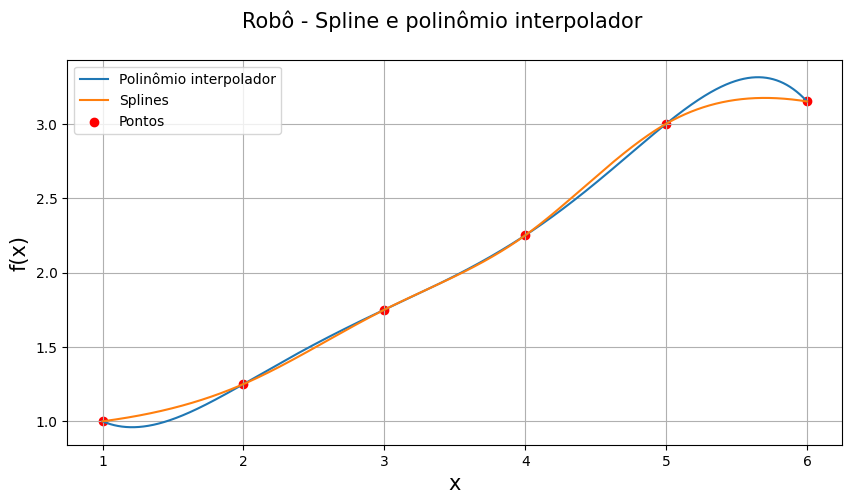

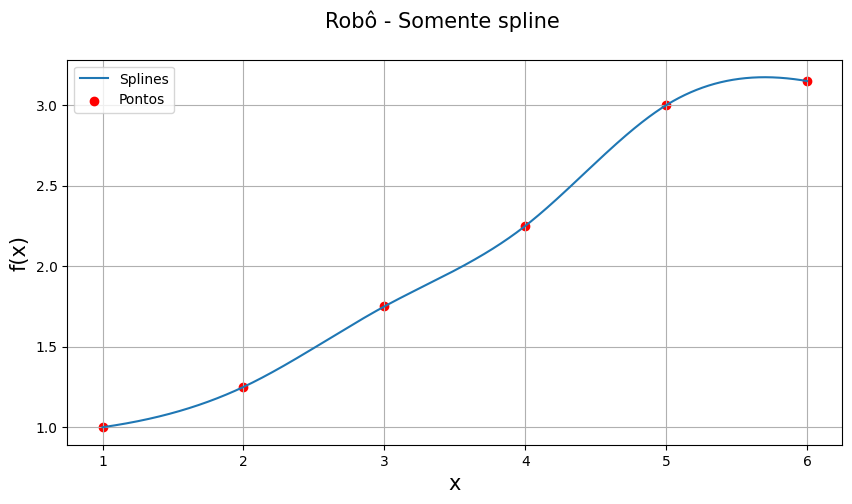

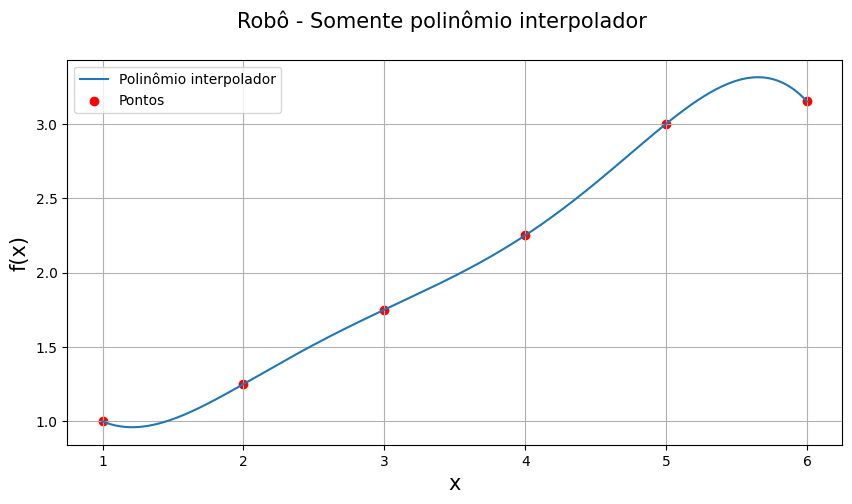


Robô - A aproximação da posição do robô em t=1.5 é: 
 f(1.5) = 1.0890998803827752


In [42]:

### Aplicação 2

print('_____________________')
print('ROBÔ')
t = [1,2,3,4,5,6]
theta = [1.0,1.25,1.75,2.25,3.0,3.15]

roboSpline = ClampedCubicSpline(t,theta,0.125,-0.15)
roboPolinomio = DividedDiferences(t,theta)

Xbase = np.linspace(1,6,10000)
YSpline = [roboSpline.polinom(x) for x in Xbase]
YPolinomio = [roboPolinomio.polinom(x) for x in Xbase]


fig1 = plt.figure(figsize = (10,5))
fig1.suptitle('Robô - Spline e polinômio interpolador', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, YPolinomio, label = "Polinômio interpolador")
plt.plot(Xbase, YSpline, label = "Splines")
plt.scatter(t, theta, label = "Pontos", color = "r")
plt.legend(fontsize=10)
plt.show()

fig2 = plt.figure(figsize = (10,5))
fig2.suptitle('Robô - Somente spline', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, YSpline, label = "Splines")
plt.scatter(t, theta, label = "Pontos", color = "r")
plt.legend(fontsize=10)
plt.show()

fig3 = plt.figure(figsize = (10,5))
fig3.suptitle('Robô - Somente polinômio interpolador', fontsize = 15)
plt.xlabel('x', fontsize = 15)
plt.ylabel('f(x)', fontsize = 15)
plt.grid()
plt.plot(Xbase, YPolinomio, label = "Polinômio interpolador")
plt.scatter(t, theta, label = "Pontos", color = "r")
plt.legend(fontsize=10)
plt.show()

# print()
# print('Robô - os coeficientes do spline são: ')
# print(pd.DataFrame({'A':roboSpline.a,'B':roboSpline.b,'C':roboSpline.c,'D':roboSpline.d,'j':range(len(roboSpline.a))}).set_index('j'))

# # coeficientes polinomio de newton
# print()
# print('Robô - os coeficientes do polinômio interpolador são: ')
# print(pd.DataFrame({'coeficientes':[roboPolinomio.coefs[i,i] for i in range(len(roboPolinomio.coefs))]}))

print()
print('Robô - A aproximação da posição do robô em t=1.5 é: \n f(1.5) = ',end='')
print(roboSpline.polinom(1.5))

# # B)

# # C)
# def deriv(f,x,h=0.01):
#     return (f(x+h)-f(x))/h

# deriv(roboSpline.polinom,1.5)


In [ ]:


def testeTempo():
    from time import time

    n = 10000000
    x = np.linspace(0,10,n)
    y = np.random.random(n)

    ini = time()
    spline = NaturalCubicSpline(x,y)
    print(spline.polinom(1))
    print(f'fim = {time()-ini}')

    from scipy.interpolate import interp1d 

    ini = time()
    spline = interp1d(x, y, kind='cubic') 
    print(spline(1))
    print(f'fim = {time()-ini}')

testeTempo()

In [43]:
pd.DataFrame({'Aj':roboSpline.a,'Bj':roboSpline.b,'Cj':roboSpline.c,'Dj':roboSpline.d,'j':range(len(roboSpline.a))}).set_index('j')
#pd.DataFrame({'coeficientes':[roboPolinomio.coefs[i,i] for i in range(len(roboPolinomio.coefs))]})


,Aj,Bj,Cj,Dj
j,,,,
0,1.00,0.125000,0.087799,0.037201
1,1.25,0.412201,0.199402,-0.111603
2,1.75,0.476196,-0.135407,0.159211
3,2.25,0.683014,0.342225,-0.275239
4,3.00,0.541746,-0.483493,0.091746


In [44]:
def deriv(f,x,h=0.0001):
    return (f(x+h)-f(x))/h

deriv(roboSpline.polinom,1.5)

0.24071412118464863

In [48]:
print(roboPolinomio.coefs)

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 1.25        0.25        0.          0.          0.          0.        ]
 [ 1.75        0.5         0.125       0.          0.          0.        ]
 [ 2.25        0.5         0.         -0.04166667  0.          0.        ]
 [ 3.          0.75        0.125       0.04166667  0.02083333  0.        ]
 [ 3.15        0.15       -0.3        -0.14166667 -0.04583333 -0.01333333]]


In [49]:
10*0.1415/384

0.003684895833333333